In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re

In [2]:
# explore training data
data = pd.read_csv('./full.csv')
data.head()

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid
0,531010,TROY MIKEL HOKE,6/30/2019 4:24:07 AM,"DES MOINES, IA",PCJ,28,"5' 09""",160,White,Male,Brown,Brown,296174
1,695392,MARTIN WAYNE LOONEY,7/12/2019 10:59:29 AM,"URBANDALE, IA",PCJ,26,"6' 00""",175,Black,Male,Brown,Black,296824
2,850957,REESE WAYNE WEGENER,7/9/2019 4:59:27 PM,"DES MOINES, IA",WASH-M,30,"6' 00""",180,White,Male,Blue,Brown,296645
3,559407,TALONDA NASHAWN SCALES,6/30/2019 8:17:39 PM,"DES MOINES, IA",PCJ,37,"5' 00""",168,Black,Female,Brown,Black,296194
4,65861,RACHELLE ANGELIC JONES,3/18/2019 12:53:17 PM,"DES MOINES, IA",PCJ,31,"5' 08""",190,Black,Female,Brown,Black,290118


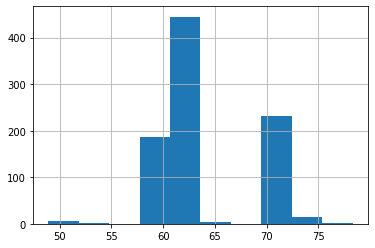

In [3]:
data['height'] = data.height.map(lambda i: re.sub('[^0-9]','',i)).map(lambda i: float(i[0])*12 + float(i[1:])/10)
data.height.hist()

In [4]:
data['bmi'] = data.weight / data.height.map(lambda i: i**2) * 703
data = data.loc[(data.weight >0) & (data.height > 0),:]
data.head()

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid,bmi
0,531010,TROY MIKEL HOKE,6/30/2019 4:24:07 AM,"DES MOINES, IA",PCJ,28,60.9,160,White,Male,Brown,Brown,296174,30.327787
1,695392,MARTIN WAYNE LOONEY,7/12/2019 10:59:29 AM,"URBANDALE, IA",PCJ,26,72.0,175,Black,Male,Brown,Black,296824,23.731674
2,850957,REESE WAYNE WEGENER,7/9/2019 4:59:27 PM,"DES MOINES, IA",WASH-M,30,72.0,180,White,Male,Blue,Brown,296645,24.409722
3,559407,TALONDA NASHAWN SCALES,6/30/2019 8:17:39 PM,"DES MOINES, IA",PCJ,37,60.0,168,Black,Female,Brown,Black,296194,32.806667
4,65861,RACHELLE ANGELIC JONES,3/18/2019 12:53:17 PM,"DES MOINES, IA",PCJ,31,60.8,190,Black,Female,Brown,Black,290118,36.132812


In [5]:
pd.Series.quantile(data.bmi, np.arange(0,1.1,0.1))

0.0    16.951196
0.1    23.053627
0.2    25.134141
0.3    27.055054
0.4    28.683805
0.5    30.337170
0.6    32.096701
0.7    33.965149
0.8    35.778861
0.9    39.571009
1.0    62.214761
Name: bmi, dtype: float64

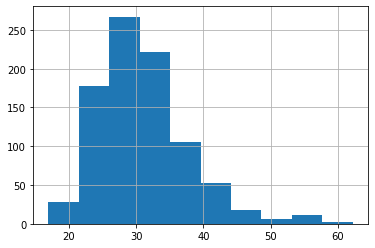

In [6]:
data.bmi.hist()

In [7]:
data['label'] = data.bmi.map(lambda i: '1_bmi_over_30' if i > 30 else '0_bmi_below_30')
data.label.value_counts()

1_bmi_over_30     468
0_bmi_below_30    421
Name: label, dtype: int64

In [8]:
# put train/valid data

In [9]:
import shutil
from pathlib import Path

In [10]:
TRAIN_PATH = './train'
VALID_PATH = './valid'
IN_TRAIN_RATIO = 0.9

In [11]:
def create_train_valid(path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents = True)

In [12]:
create_train_valid(Path(TRAIN_PATH, '0'))
create_train_valid(Path(TRAIN_PATH, '1'))
create_train_valid(Path(VALID_PATH, '0'))
create_train_valid(Path(VALID_PATH, '1'))

In [13]:
in_train = np.random.uniform(size = len(data)) < IN_TRAIN_RATIO

In [14]:
def move_image(bookids, path):
    for bookid in bookids:
        try:
            shutil.copy(Path('./face','{}.jpg'.format(bookid)), path)
        except:
            print('./face/{}.jpg missing'.format(bookid))
            continue

In [15]:
print('1) moving train set - label 1')
move_image(data.loc[(data.bmi > 30) & (in_train),'bookid'].values, Path(TRAIN_PATH,'1'))
print('2) moving train set - label 0')
move_image(data.loc[(data.bmi <= 30) & (in_train),'bookid'].values, Path(TRAIN_PATH,'0'))
print('3) moving valid set - label 1')
move_image(data.loc[(data.bmi > 30) & (~in_train),'bookid'].values, Path(VALID_PATH,'1'))
print('4) moving valid set - label 0')
move_image(data.loc[(data.bmi <= 30) & (~in_train),'bookid'].values, Path(VALID_PATH,'0'))

1) moving train set - label 1
./face/296500.jpg missing
./face/296874.jpg missing
2) moving train set - label 0
./face/297231.jpg missing
3) moving valid set - label 1
4) moving valid set - label 0


In [16]:
# train model

In [17]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [18]:
DROP_RATE = 0.0

In [19]:
base_model = ResNet50(weights = 'imagenet', include_top = False)

/home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROP_RATE)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

W0804 18:01:34.277585 139987261196096 deprecation.py:506] From /home/chaoran/anaconda3/envs/mypy36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
model = Model(base_model.input, x)

In [22]:
num_base_model_layers = len(base_model.layers)
for layer in model.layers[:num_base_model_layers]:
    layer.trainable = False
for layer in model.layers[num_base_model_layers:]:
    layer.trainable = True

In [31]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

valid_generator=train_datagen.flow_from_directory(VALID_PATH,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 793 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


In [32]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [36]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

device_lib.list_local_devices()

In [33]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                    validation_data=valid_generator,
                   epochs=10)

Epoch 1/10
24/24 [==============================] - 42s 2s/step - loss: 0.5510 - acc: 0.7175 - val_loss: 0.8731 - val_acc: 0.5806
Epoch 2/10
24/24 [==============================] - 41s 2s/step - loss: 0.5080 - acc: 0.7543 - val_loss: 0.8505 - val_acc: 0.6022
Epoch 3/10
24/24 [==============================] - 41s 2s/step - loss: 0.5129 - acc: 0.7464 - val_loss: 1.1359 - val_acc: 0.5806
Epoch 4/10
24/24 [==============================] - 41s 2s/step - loss: 0.4749 - acc: 0.7674 - val_loss: 0.7359 - val_acc: 0.6237
Epoch 5/10
24/24 [==============================] - 41s 2s/step - loss: 0.4078 - acc: 0.8344 - val_loss: 0.7757 - val_acc: 0.6237
Epoch 6/10
24/24 [==============================] - 41s 2s/step - loss: 0.3967 - acc: 0.8252 - val_loss: 0.6997 - val_acc: 0.5699
Epoch 7/10
24/24 [==============================] - 42s 2s/step - loss: 0.3865 - acc: 0.8242 - val_loss: 0.6983 - val_acc: 0.5914
Epoch 8/10
24/24 [==============================] - 41s 2s/step - loss: 0.3961 - acc: 0.80

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 640886491962348914, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10890493626314718114
 physical_device_desc: "device: XLA_CPU device"]